In [108]:
from datetime import datetime, timedelta
import os
import statistics
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
# Function to parse job time string to timedelta
def parse_job_time(job_time_str):
    hours, minutes, seconds = map(int, job_time_str.split(':'))
    return timedelta(hours=hours, minutes=minutes, seconds=seconds)


# Function to parse the start time string to datetime
def parse_start_time(job_time_str):
    return datetime.strptime(job_time_str, '%Y-%m-%d %H:%M:%S')


# Function to get the job times for each benchmark (in seconds), for all runs (files)
def get_batch_times(files):
    # Create a dictionary with all the key-values : job_name --> [t1, t2, t3]
    batch_execution_times = {}
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Job:'):
                    batch_name = line.split(': ')[1].strip()
                elif line.startswith('Job time:'):
                    job_time_str = line.split(': ')[1].strip()
                    job_time = parse_job_time(job_time_str)
                    if batch_name in batch_execution_times:
                        batch_execution_times[batch_name].append(job_time.total_seconds())
                    else:
                        batch_execution_times[batch_name] = [job_time.total_seconds()]
    return batch_execution_times


# Function to calculate mean and standard deviation of job time for each batch application
def calculate_batch_means_and_stds(files):
    batch_execution_times = get_batch_times(files)
    # Create mean and std dictionaries with all key-values: job_name --> mean and job_name --> std
    batch_means = {}
    batch_stds = {}
    for batch_name, execution_times in batch_execution_times.items():
        batch_means[batch_name] = statistics.mean(execution_times)
        batch_stds[batch_name] = statistics.stdev(execution_times)

    return batch_means, batch_stds


# Function to get the total job time (in seconds) for each file
def get_total_job_times(files):
    job_times = list()
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Total time:'):
                    job_time = parse_job_time(line.split(': ')[1].strip())
                    job_times.append(job_time.total_seconds())
    return job_times


# Function to calculate relative starting times in seconds for each job
def calculate_relative_start_times(files):
    relative_start_times = list()
    for file in files:
        start_times = list()
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Start time:'):
                    start_time = parse_start_time(line.split(': ')[1].strip())
                    start_times.append(start_time)
        min_start_time = min(start_times)
        relative_start_times.append([(start_time - min_start_time).total_seconds() for start_time in start_times])
    
    return relative_start_times


# Function to parse ts_start and ts_end to datetime objects
def parse_timestamp(timestamp_str):
    return datetime.fromtimestamp(int(timestamp_str) / 1000)


# Function to parse the mcperf file
def parse_mcperf_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    
    header = lines[0].split()
    column_indices = {header[i]: i for i in range(len(header))} # To get automatically the correct columns instead of hardcoding indeces
    data = {'p95': [], 'QPS':[], 'target':[], 'ts_start': [], 'ts_end': []}
    for line in lines[1:]:  # To skip the header line
        parts = line.split()
        data['p95'].append(float(parts[column_indices['p95']]))
        data['QPS'].append(float(parts[column_indices['QPS']]))
        data['target'].append(float(parts[column_indices['target']]))
        data['ts_start'].append(parse_timestamp(parts[column_indices['ts_start']]))
        data['ts_end'].append(parse_timestamp(parts[column_indices['ts_end']]))

    df = pd.DataFrame(data)
    return df


# Function to arrange times in a format convenient for plotting
def arrange_times(batch_times, total_times, n_runs):
    arranged_times = list()
    for i in range(n_runs):
        tmp = list()
        for value in batch_times.values():
            tmp.append(value[i])
        tmp.append(total_times[i])
        arranged_times.append(tmp)
    return arranged_times

In [110]:
files = ["measurements/tmp_3/pods_0.txt", "measurements/tmp_3/pods_1.txt", "measurements/tmp_3/pods_2.txt"]
mcperf_files = ["measurements/tmp_2/mcperf_0.txt", "measurements/tmp_2/mcperf_1.txt", "measurements/tmp_2/mcperf_2.txt"]

In [111]:
# Calculate batch means and standard deviations
batch_means, batch_stds = calculate_batch_means_and_stds(files)

print("Batch Application Means:")
for batch_name, mean in batch_means.items():
    print(f"{batch_name}: {mean:.2f} seconds")

print("\nBatch Application Standard Deviations:")
for batch_name, std in batch_stds.items():
    print(f"{batch_name}: {std:.2f} seconds")

# Get total job times (in seconds) for each file and convert them to seconds
total_job_times = get_total_job_times(files)
print("\nTotal Job Time Across All Files:", total_job_times)

# Calculate mean and standard deviation of the total time to complete all jobs (makespan)
makespan_mean = statistics.mean(total_job_times)
makespan_stdev = statistics.stdev(total_job_times)
print("\nMakespan Mean:", makespan_mean, "seconds")
print("Makespan Standard Deviation:", makespan_stdev, "seconds")


Batch Application Means:
parsec-blackscholes: 51.67 seconds
parsec-canneal: 130.00 seconds
parsec-dedup: 20.00 seconds
parsec-ferret: 140.33 seconds
parsec-freqmine: 169.67 seconds
parsec-radix: 18.67 seconds
parsec-vips: 109.33 seconds

Batch Application Standard Deviations:
parsec-blackscholes: 2.89 seconds
parsec-canneal: 2.65 seconds
parsec-dedup: 6.08 seconds
parsec-ferret: 9.81 seconds
parsec-freqmine: 15.18 seconds
parsec-radix: 0.58 seconds
parsec-vips: 30.44 seconds

Total Job Time Across All Files: [187.0, 196.0, 184.0]

Makespan Mean: 189.0 seconds
Makespan Standard Deviation: 6.244997998398398 seconds


In [112]:
times = get_batch_times(files)

In [113]:
total_times = get_total_job_times(files)

In [114]:
n_runs = 3
arranged_times = arrange_times(times, total_times, 3)

In [374]:
arranged_times

[[55.0, 133.0, 23.0, 146.0, 186.0, 19.0, 120.0, 187.0],
 [50.0, 128.0, 24.0, 146.0, 167.0, 19.0, 75.0, 196.0],
 [50.0, 129.0, 13.0, 129.0, 156.0, 18.0, 133.0, 184.0]]

In [120]:
# Get the relative job time spans wrt the first run job(s)
relative_start_times = calculate_relative_start_times(files)
print(relative_start_times)

[[14.0, 0.0, 24.0, 1.0, 1.0, 14.0, 39.0], [20.0, 4.0, 28.0, 4.0, 4.0, 0.0, 121.0], [0.0, 10.0, 3.0, 19.0, 28.0, 0.0, 21.0]]


In [432]:
mcperf_dfs = list()
memcached_spans = list()
for file in mcperf_files:
    df = parse_mcperf_file(file)
    memcached_span = (df['ts_end'].iloc[-1] - df['ts_start'].iloc[0]).total_seconds()
    memcached_spans.append(memcached_span)
    df['ts_span'] = (df['ts_end'] - df['ts_start']).dt.total_seconds()
    df = df[['p95', 'QPS', 'target', 'ts_span']]
    mcperf_dfs.append(df)

In [119]:
mcperf_dfs[0]

,p95,QPS,target,ts_span
0,596.7,29942.4,30000.0,10.150
1,683.0,29984.7,30005.0,10.126
2,729.2,29994.4,30010.0,10.108
3,567.1,30023.3,30015.0,10.108
4,679.8,30043.5,30020.0,10.116
5,623.8,30039.8,30025.0,10.105
6,598.6,30077.4,30030.0,10.155
7,641.0,29920.8,30035.0,10.134
8,587.4,30100.6,30040.0,10.126
9,625.1,29986.8,30045.0,10.107


In [379]:
execution_times[0]

[55.0, 133.0, 23.0, 146.0, 186.0, 19.0, 120.0, 187.0]

In [381]:
positions

[[14.0, 0.0, 24.0, 1.0, 1.0, 14.0, 39.0],
 [20.0, 4.0, 28.0, 4.0, 4.0, 0.0, 121.0],
 [0.0, 10.0, 3.0, 19.0, 28.0, 0.0, 21.0]]

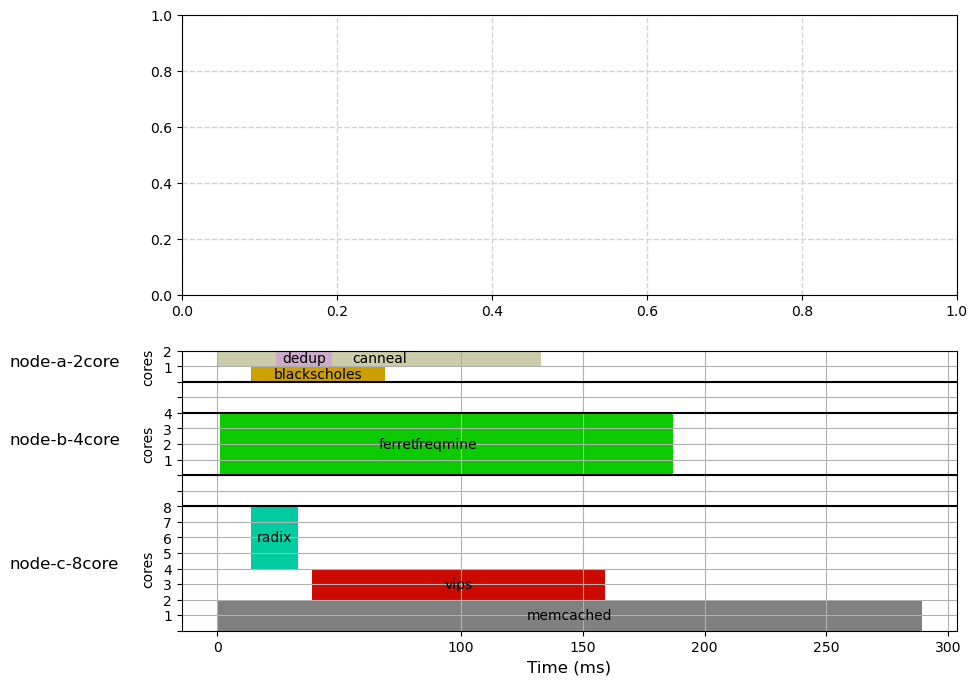

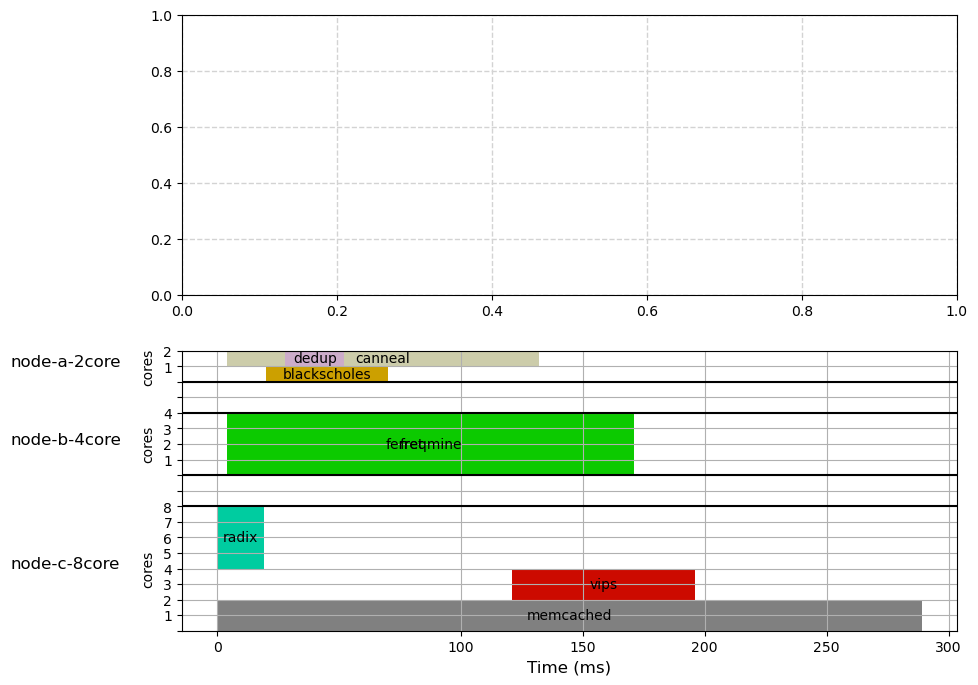

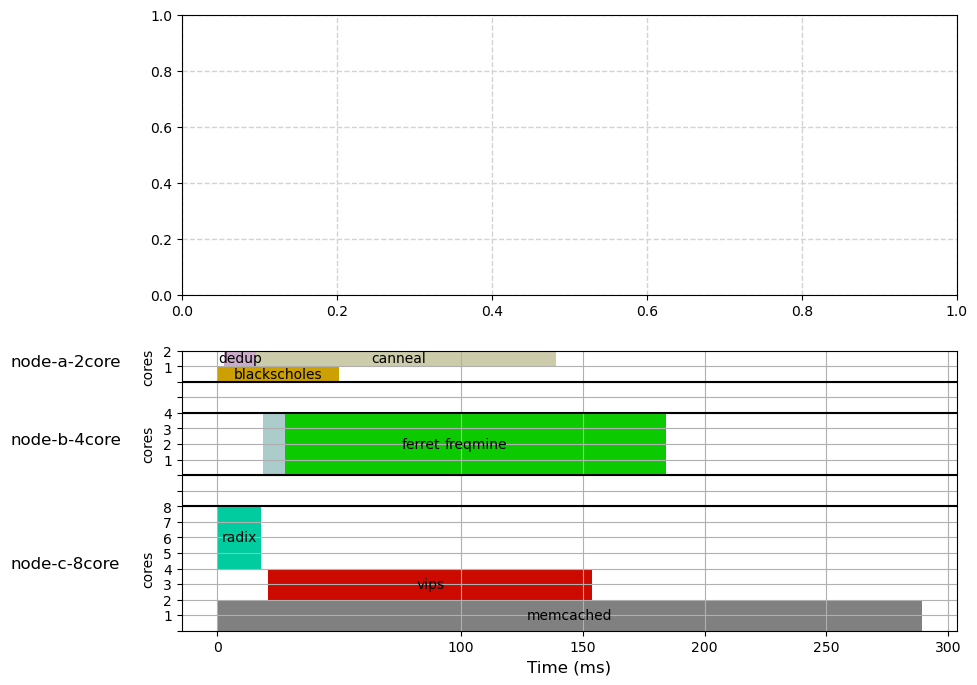

In [451]:
colors = {'canneal': '#CCCCAA', 'dedup': '#CCACCA', 'blackscholes': '#CCA000',
          'ferret': '#AACCCA', 'freqmine': '#0CCA00',
          'memcached': 'grey', 'radix': '#00CCA0', 'vips': '#CC0A00'}

job_names = ['blackscholes', 'canneal', 'dedup', 'ferret', 'freqmine', 'radix', 'vips', 'memcached']
core_allocations = [1, 1, 1, 4, 4, 4, 4, 2]  # Numero di core assegnati a ciascun job


for i in range(n_runs):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8), dpi=100)
    
    # First plot: //TODO
    
    # Second plot:
    ax2.set_xlabel("Time (ms)", fontsize = 12)
    ax2.set_ylim(0, 18)
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
    ax2.set_yticklabels(['', '1', '2', '3', '4', '5', '6', '7', '8', '', '', '1', '2', '3', '4', '', '', '1', '2'])
    ax2.set_xticks([0, 100, 150, 200, 250, 300, 350, 400])
    ax2.axhline(y=8, color='black', linestyle='-')
    ax2.axhline(y=10, color='black', linestyle='-')
    ax2.axhline(y=14, color='black', linestyle='-')
    ax2.axhline(y=16, color='black', linestyle='-')
    ax2.grid(True)
    
    # In order of appearance in pods_{i}.txt (time lists indeces):
    # Blackscholes
    ax2.broken_barh([(relative_start_times[i][0], arranged_times[i][0])], (16, 1), facecolors = colors['blackscholes'])
    ax2.annotate('blackscholes', ((relative_start_times[i][0]*2 + arranged_times[i][0])/2, 16.5), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Canneal
    ax2.broken_barh([(relative_start_times[i][1], arranged_times[i][1])], (17, 1), facecolors = colors['canneal'])
    ax2.annotate('canneal', ((relative_start_times[i][1]*2 + arranged_times[i][1])/2, 17.5), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')

    # Dedup
    ax2.broken_barh([(relative_start_times[i][2], arranged_times[i][2])], (17, 1), facecolors = colors['dedup'])
    ax2.annotate('dedup', ((relative_start_times[i][2]*2 + arranged_times[i][2])/2, 17.5), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Ferret
    ax2.broken_barh([(relative_start_times[i][3], arranged_times[i][3])], (10, 4), facecolors = colors['ferret'])
    ax2.annotate('ferret', ((relative_start_times[i][3]*2 + arranged_times[i][3])/2, 12), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Freqmine
    ax2.broken_barh([(relative_start_times[i][4], arranged_times[i][4])], (10, 4), facecolors = colors['freqmine'])
    ax2.annotate('freqmine', ((relative_start_times[i][4]*2 + arranged_times[i][4])/2, 12), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Radix
    ax2.broken_barh([(relative_start_times[i][5], arranged_times[i][5])], (4, 4), facecolors = colors['radix'])
    ax2.annotate('radix', ((relative_start_times[i][5]*2 + arranged_times[i][5])/2, 6), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Vips
    ax2.broken_barh([(relative_start_times[i][6], arranged_times[i][6])], (2, 2), facecolors = colors['vips'])
    ax2.annotate('vips', ((relative_start_times[i][6]*2 + arranged_times[i][6])/2, 3), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Memcached
    ax2.broken_barh([(0, memcached_spans[i])], (0, 2), facecolors = colors['memcached'])
    ax2.annotate('memcached', (memcached_spans[i]/2, 1), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # y-axis annotations
    ax2.text(-85, 4, 'node-c-8core', rotation=0, fontsize=12)
    ax2.text(-31, 3, 'cores', rotation=90, fontsize=10)
    
    ax2.text(-85, 12, 'node-b-4core', rotation=0, fontsize=12)
    ax2.text(-31, 11, 'cores', rotation=90, fontsize=10)
    
    ax2.text(-85, 17, 'node-a-2core', rotation=0, fontsize=12)
    ax2.text(-31, 16, 'cores', rotation=90, fontsize=10)
    
    # ax1 style
    ax1.grid(True, color='lightgray', linestyle='--', linewidth=1)
    plt.show()
    #plt.title('Run ' + str(i+1), fontsize = 14)
    #plt.tight_layout()

    #plt.savefig("plot_" + str(i) + ".pdf", bbox_inches = "tight")

In [257]:
for i in range(0, 19, 2):
    print(i)

0
2
4
6
8
10
12
14
16
18


C:\Users\chris\AppData\Local\Temp\ipykernel_1680\821743743.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(ylabs_parsec)


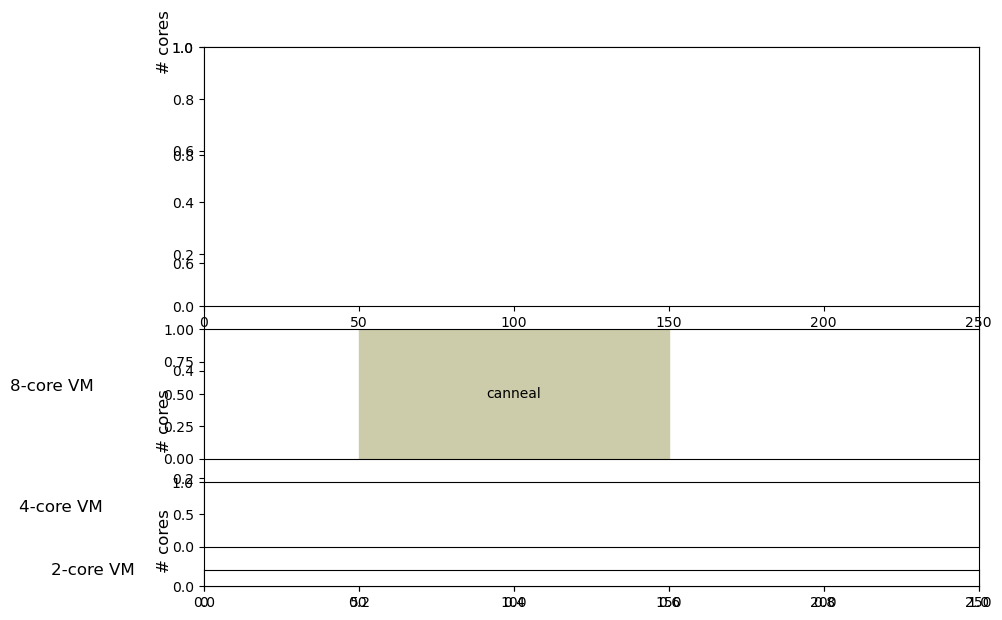

In [358]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Simulazione dei dati
vm2_jobs = ['canneal', 'dedup', 'blackscholes']
vm4_jobs = ['ferret', 'freqmine']
vm8_jobs = ['memcached', 'radix', 'vips']
execution_times = [100, 70, 50, 200, 150, 90, 120, 80]  # Tempi di esecuzione in millisecondi
core_allocations = [1, 1, 1, 4, 4, 2, 4, 2]  # Numero di core assegnati a ciascun job

# Creazione del grafico
fig = plt.subplots(figsize=(10, 7))
gs = gridspec.GridSpec(4, 1, height_ratios=[16, 8, 4, 1])
t = gs.get_subplot_params()
# Definizione dei colori per ciascun job
colors = {'canneal': '#CCCCAA', 'dedup': '#CCACCA', 'blackscholes': '#CCA000',
          'ferret': '#AACCCA', 'freqmine': '#0CCA00',
          'memcached': 'grey', 'radix': '#00CCA0', 'vips': '#CC0A00'}

# Definizione delle posizioni dei rettangoli sul grafico
positions = {'canneal': 0.5, 'dedup': 1.5, 'blackscholes': 2.5,
             'ferret': 4, 'freqmine': 5.5,
             'memcached': 7, 'radix': 8.5, 'vips': 10}

## ----- ax ----- ##
ax = plt.subplot(gs[0])
ax.set_xlim(0, max(execution_times) + 50)


## ----- ax1 ----- ##
ax1 = plt.subplot(gs[1])
ax1.set_xlim(0, max(execution_times) + 50)
ax1.set_xticks([])

ax1.set_ylabel('8-core VM', fontsize=12, rotation=0, labelpad=80)
ax1.text(-15, 3, '# cores', rotation=90, fontsize=12)

## ----- ax2 ----- ##
ax2 = plt.subplot(gs[2])
ax2.set_xlim(0, max(execution_times) + 50)
ax2.set_xticks([])

ax2.set_ylabel('4-core VM', fontsize=12, rotation=0, labelpad=80)
ax2.text(-15, 1.5, '# cores', rotation=90, fontsize=12)

## ----- ax3 ----- ##
ax3 = plt.subplot(gs[3])
ax3.set_xlim(0, max(execution_times) + 50)

ax3.set_yticklabels(ylabs_parsec)
ax3.set_ylabel('2-core VM', fontsize=12, rotation=0, labelpad=80)
ax3.text(-15, 1, '# cores', rotation=90, fontsize=12)


# VM2
ax1.add_patch(plt.Rectangle((execution_times[0] / 2, positions[vm2_jobs[0]] - core_allocations[0] / 2), 
                           execution_times[0], core_allocations[0], color=colors[vm2_jobs[0]]))
ax1.text(execution_times[0] / 2 + execution_times[0] / 2, positions[vm2_jobs[0]], vm2_jobs[0], ha='center', va='center')

# VM4

# VM8






# Mostra il grafico
plt.yticks([])
plt.grid(False)
plt.show()


In [159]:
times

{'parsec-blackscholes': [55.0, 50.0, 50.0],
 'parsec-canneal': [133.0, 128.0, 129.0],
 'parsec-dedup': [23.0, 24.0, 13.0],
 'parsec-ferret': [146.0, 146.0, 129.0],
 'parsec-freqmine': [186.0, 167.0, 156.0],
 'parsec-radix': [19.0, 19.0, 18.0],
 'parsec-vips': [120.0, 75.0, 133.0]}

In [ ]:
import math
import matplotlib.pyplot as plt

for i in range(0, 3):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5), dpi=100)
    # First plot:
    resultsTime = [item for item in run_results[i] if not(math.isnan(item)) == True]
    resultsQPS = [item for item in run_achieved_qps[i] if not(math.isnan(item)) == True]
    time = np.linspace(start=0, stop=total_times[-1], num=len(resultsTime))

    ax[0].plot(time,np.array(resultsTime)/1000.0, color = "orange",marker = "o")
    ax[0].set_xlabel("Time (ms)", fontsize = 12)
    ax[0].set_ylabel("95th %-tile Response Time (ms)", fontsize = 10)
    ax[0].tick_params(axis='y', colors='orange')
    ax[0].yaxis.label.set_color('orange')
    ax2 = ax[0].twinx()
    ax2.plot(time,np.array(resultsQPS)/1000.0, color = "blue", marker = "o")
    ax2.set_ylabel("Achieved Queries Per Second (kQPS)", fontsize = 10)
    ax2.yaxis.label.set_color('blue')
    y2labs = ['0k', '5k','10k','15k','20k','25k','30k','35k','40k','45k','50k','55k','60k']
    ax2.set_yticks(range(0, 50, 10))
    ax2.tick_params(axis='y', colors='blue')
    
    y1labs = ['0', '1','2','3','4','5','6','7','8','9','10']
    ax[0].set_yticks([0,0.5,1,1.5,2,2.5])
    #ax[0].set_yticks(range(0,2,0))
    #ax[0].legend(['Tail response time'], fontsize=10, loc='upper left')
    #ax2.legend(['QPS'], fontsize=10,loc='upper right')


    # Second plot:
    timesJobs = total_times[i]
    startJobs = start_rel_times[i]
    ax[1].set_xlabel("Time (ms)", fontsize = 12)
    ax[1].set_ylim(0,14)
    ax[1].set_yticks([0,2,4,6,8,10,12,14, 16, 17, 18])
    ylabs_parsec = ['0','2','8-core VM, 4','6','8', '0', '4-core VM, 2', '4', '0', '2-core VM,   ', '2']
    ax[1].set_yticklabels(ylabs_parsec)
    ax[1].set_ylabel('cores')
    ax[1].set_xticks([0,100,150,200,250,300,350,400])
    ax[1].axhline(y=8, color='black', linestyle='-')
    ax[1].axhline(y=10, color='black', linestyle='-')
    ax[1].axhline(y=14, color='black', linestyle='-')
    ax[1].axhline(y=16, color='black', linestyle='-')
    
    #ax[1].set_xlim(0,450)
    #['parsecblackscholes', 'parseccanneal', 'parsecdedup', 'parsecferret', 'parsecfreqmine', 'parsec-splash2x-fft', 'memcached']
    #Memcached
    ax[1].broken_barh([(startJobs[-1],timesJobs[-1])],(16,2), facecolors = 'tab:gray')
    ax[1].annotate('memcached',(timesJobs[-1]/2,17),color='black', horizontalalignment='center', verticalalignment='center')
    #Freqmine n=4
    ax[1].broken_barh([(startJobs[4],timesJobs[4])], (0,7), facecolors = 'tab:green')
    ax[1].annotate('freqmine',(timesJobs[4]/2, 3), color = 'black', horizontalalignment='center', verticalalignment='center')
    #Canneal n=1
    ax[1].broken_barh([(startJobs[1],timesJobs[1])], (4,4), facecolors = 'tab:purple')
    ax[1].annotate('canneal',( (2*startJobs[1]+timesJobs[1])/2, 6), color = 'black', horizontalalignment='center', verticalalignment='center')
    #Blackscholes n=0
    ax[1].broken_barh([(timesJobs[5],timesJobs[0])], (3,4), facecolors = 'tab:pink')
    ax[1].annotate('blackscholes',((2*timesJobs[5]+timesJobs[0])/2, 5), color = 'black', horizontalalignment='center', verticalalignment='center')
     #FFT n=5
    ax[1].broken_barh([(startJobs[5],timesJobs[5])], (0,3), facecolors = 'tab:orange')
    ax[1].annotate('fft',((2*startJobs[5] + timesJobs[5])/2, 1.5), color = 'black', horizontalalignment='center', verticalalignment='center')
    #Ferret n=3
    ax[1].broken_barh([(startJobs[3],timesJobs[3])], (10,4), facecolors = 'tab:cyan')
    ax[1].annotate('ferret',((timesJobs[3])/2, 12), color = 'black', horizontalalignment='center', verticalalignment='center')
    #Dedup n=2
    ax[1].broken_barh([(startJobs[2],timesJobs[2])], (10,3), facecolors = 'tab:red')
    ax[1].annotate('dedup',((timesJobs[2]+2*startJobs[2])/2, 11.5), color = 'black', horizontalalignment='center', verticalalignment='center')

    ax[0].grid(True, color='lightgray', linestyle='--', linewidth=1)
    plt.title('Run ' + str(i+1), fontsize = 14)
    plt.tight_layout()

    plt.savefig("p3_run_final_" + str(i+1) + ".pdf", bbox_inches = "tight")

In [ ]:
# Function to plot the p95 latency over time for memcached as requested (hopefullly) by the handout
def plot_latency(data, ax):
    # Group data by ts_start and machine, and calculate the max p95 latency within each group
    grouped_data = data.groupby(['ts_start']).max()['p95']
    
    # Plot each group as a bar
    for (start_time, machine), latency in grouped_data.items():
        duration = data[data['ts_start'] == start_time]['ts_end'].iloc[0] - start_time
        ax.bar(start_time, latency, width=duration.total_seconds(), align='edge')

    # Add annotations for batch job start and end times
    for idx, row in data.iterrows():
        ax.annotate(row['type'], (row['ts_start'], row['p95']), textcoords="offset points", xytext=(0,10), ha='center')

    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('P95 Latency')
    ax.set_title('Memcached P95 Latency Over Time')
    ax.legend()

